# Assignement 2

#### Afonso Duarte 103913

GitHub: https://github.com/Afonso-Duarte/Intelligent-Systems-Project.git

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import seaborn as sns
from sklearn import datasets

# Regression Problem 
### Data Loading and Preparation

In [2]:
#Load Dataset 
diabetes = datasets.load_diabetes(as_frame = True)
X = diabetes.data.values
y = diabetes.target.values

diabetes.frame.head()

age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  target  
0 -0.002592  0.019907 -0.017646   151.0  
1 -0.039493 -0.068332 -0.092204    75.0  
2 -0.002592  0.002861 -0.025930   141.0  
3  0.034309  0.022688 -0.009362   206.0  
4 -0.002592 -0.031988 -0.046641   135.0

In [3]:
# First split into train and test
test_size = 0.2
Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=test_size, random_state=42
)

# Now split train into actual train and validation
val_size = 2/9  
Xtr, Xval, ytr, yval = train_test_split(
    Xtr, ytr, test_size=val_size, random_state=42
)

In [4]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)
Xval= scaler.transform(Xval)

### Clustering Parameters

Fuzzy C-means clustering was performed with two clusters and a fuzziness parameter of 2. Clustering quality was assessed using the Fuzzy Partition Coefficient (FPC), which yielded a value of 0.856, indicating good cluster separation. Preliminary tests with a higher number of clusters resulted in lower FPC values, suggesting that two clusters provided the most distinct partitioning of the data. The algorithm was configured with a convergence tolerance of 0.005 and a high iteration limit of 1000 to ensure convergence to a stable solution.

In [5]:
# Number of clusters 
n_clusters = 2
m=2

# Concatenate target for clustering
Xexp= np.concatenate([Xtr, ytr.reshape(-1,1)], axis=1)
#Xexp=Xtr

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T 

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

In [6]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)# Hard clustering from fuzzy membership

# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)

Fuzzy partition coefficient (FPC): 0.863240699468764


To visualize the clustering results, the data were converted into a pandas DataFrame and plotted using a pairplot with cluster labels as the hue. This allowed for inspection of the feature distributions and their separation across the two clusters. Some plots display a binary-like pattern, which is expected because certain features, such as sex, are categorical variables encoded numerically. These plots confirm that the clustering meaningfully captures differences related to these features.


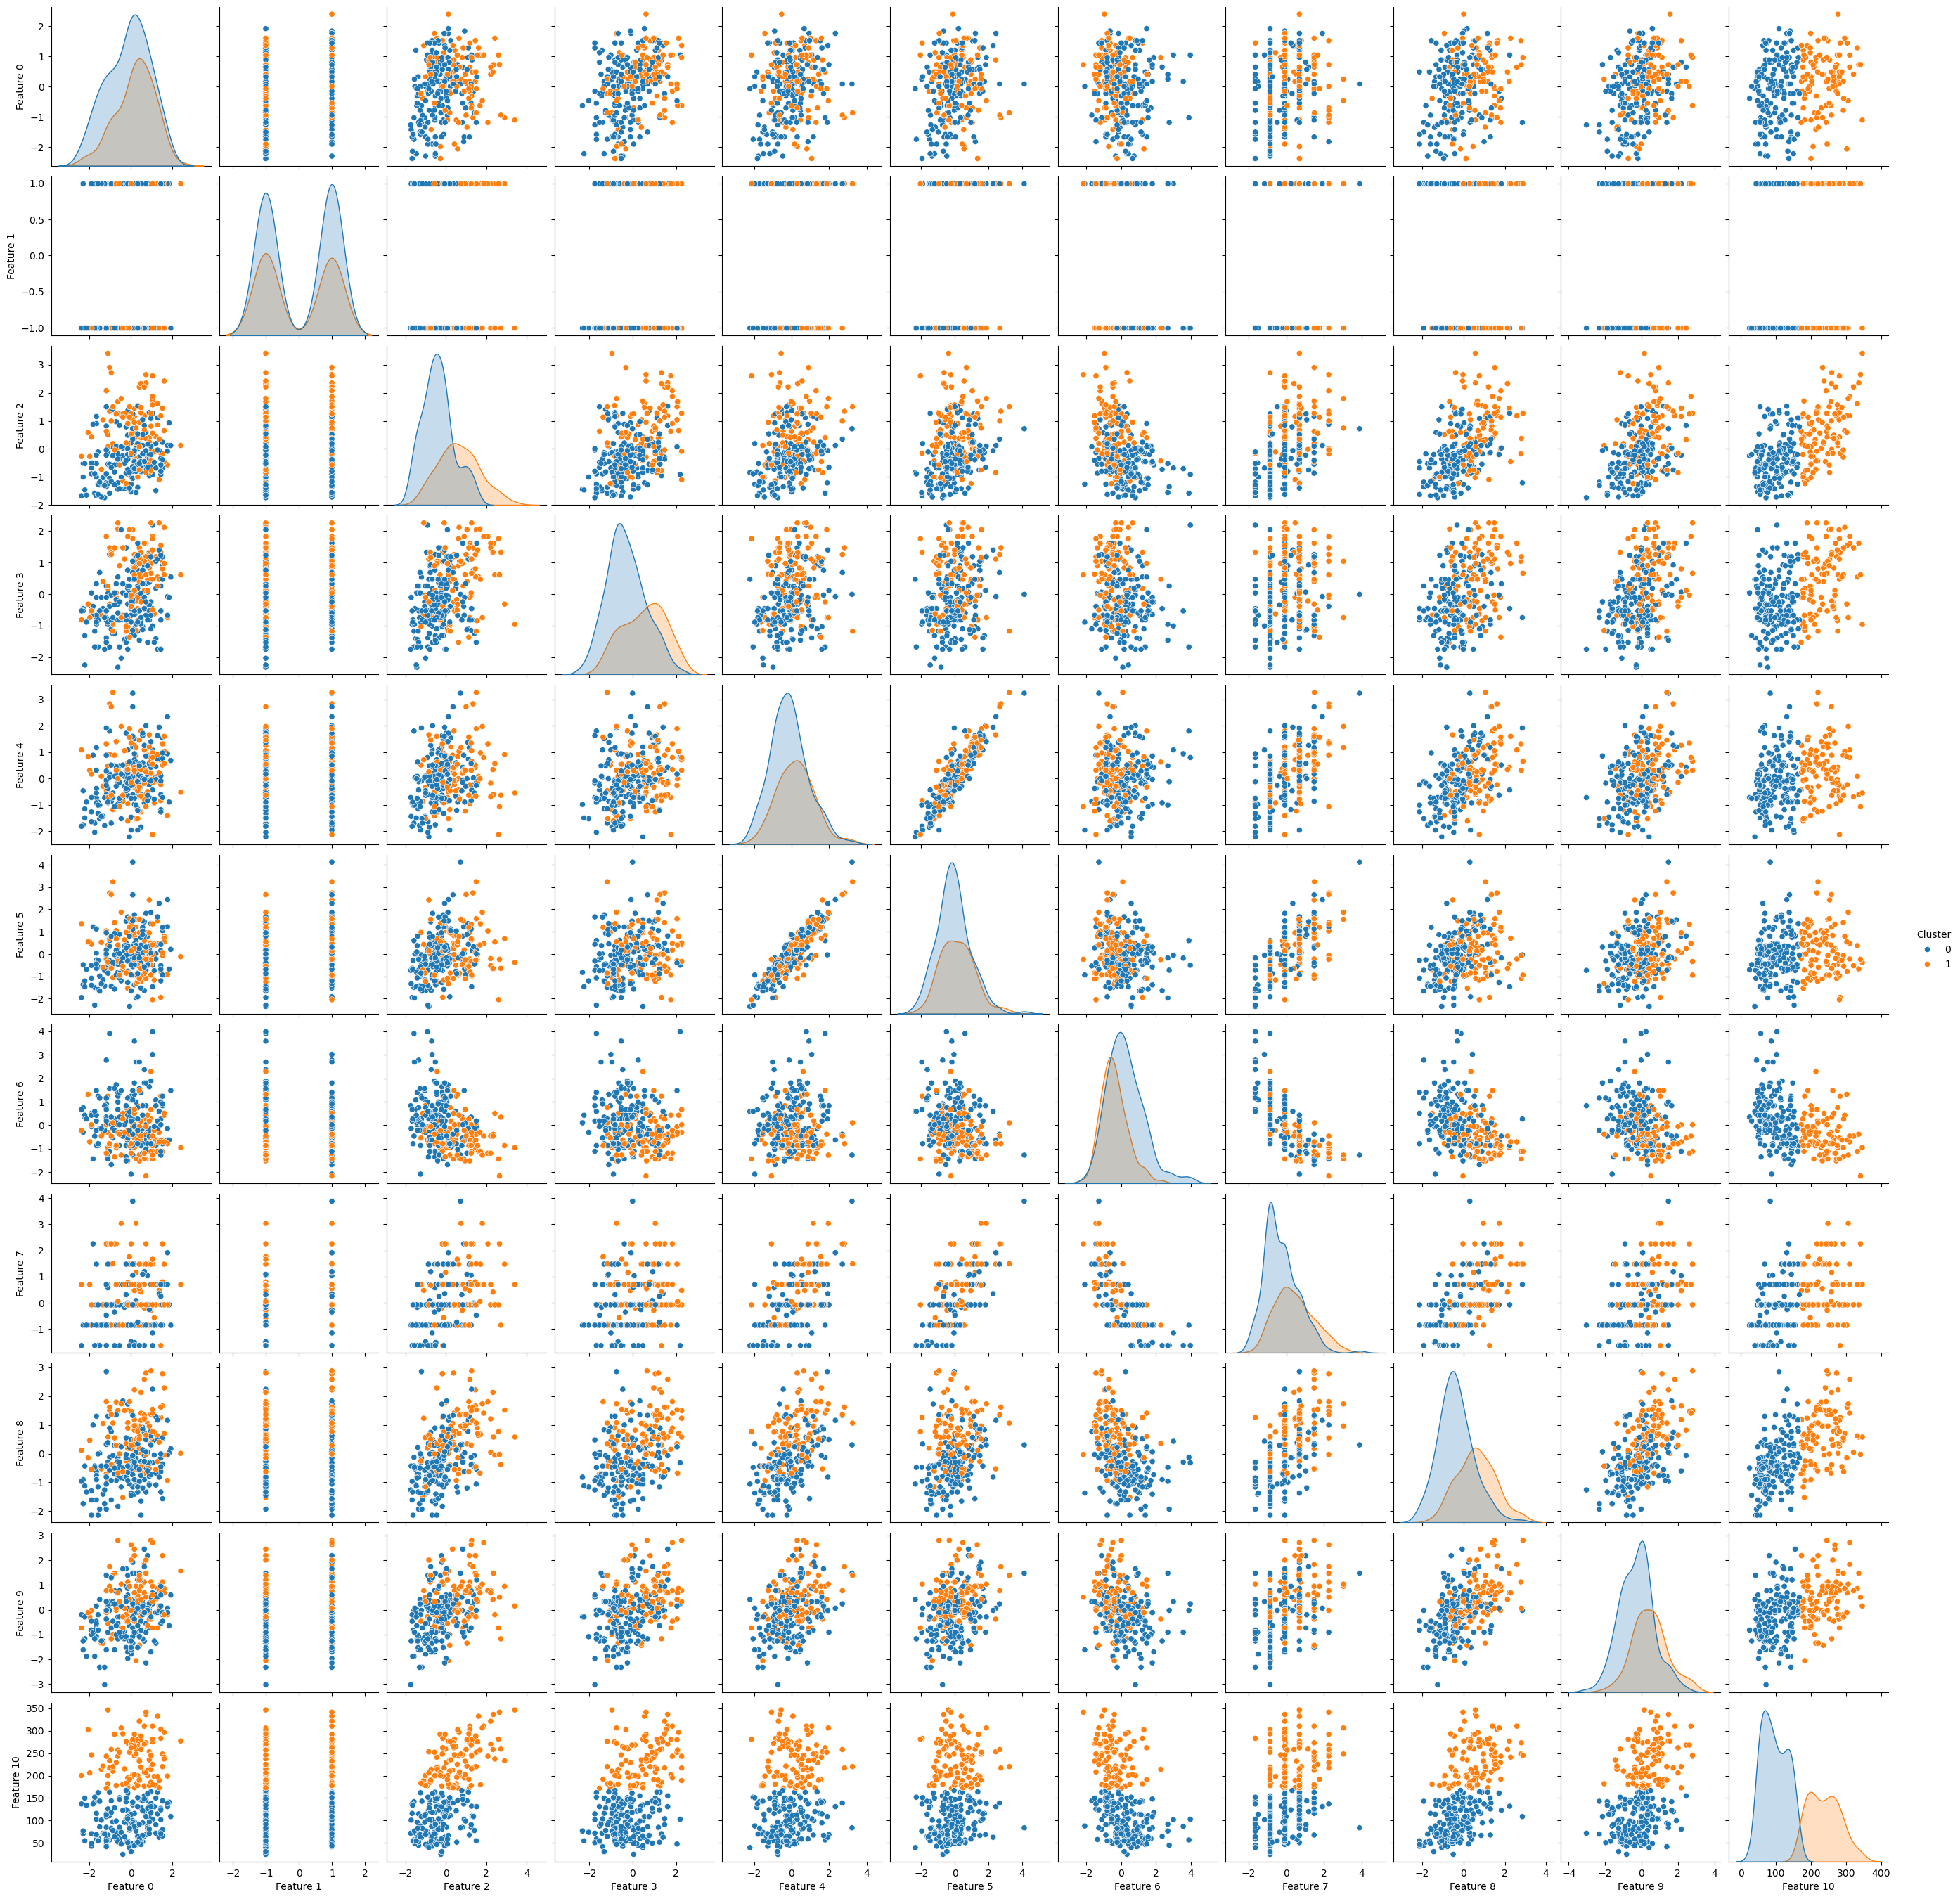

In [7]:
cluster_labels = np.argmax(u, axis=0)  

# Turn Xexp into a dataframe for plotting
df = pd.DataFrame(Xexp, columns=[f"Feature {i}" for i in range(Xexp.shape[1])])
df["Cluster"] = cluster_labels

# Pairplot with hue = cluster
sns.pairplot(df, vars=df.columns[:-1], hue="Cluster", palette="tab10", diag_kind="kde")
plt.show()

### Takagi–Sugeno–Kang (TSK) Fuzzy Inference Model Implementation

This section defines the core of the TSK fuzzy inference system used for the model. The GaussianMF class implements Gaussian membership functions for each rule, parameterized by learnable centers and spreads (μ and σ). The forward pass computes the degree of membership for each input sample and aggregates the distances either probabilistically (using the Euclidean norm) or using a max-based approach for stricter rule activation.

The TSK class combines these membership functions with a rule base where each rule has a set of consequent parameters forming a linear function of the inputs (plus a bias). During the forward pass, the model computes the firing strengths of each rule, normalizes them to obtain rule weights, and then performs a weighted sum of the rule outputs. This yields a smooth, differentiable mapping from input features to output predictions, making the model trainable with gradient-based optimization.

This implementation allows the TSK model to adapt both the fuzzy partitions (centers and sigmas) and the consequent parameters during training, enabling it to capture nonlinear input–output relationships while remaining interpretable.

In [8]:
# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs

## Model Training

The train_ls function applies a Least Squares (LS) method to solve for the consequent parameters of the Takagi–Sugeno–Kang (TSK) fuzzy rules. It constructs a design matrix that combines the normalized firing strengths of the rules with the input data and solves the linear system. This allows the consequents of the rules to be fitted directly in closed form. In contrast, the train_gd function updates model parameters using gradient descent with Adam, minimizing the mean squared error loss in a traditional iterative optimization fashion. Finally, the train_hybrid_anfis function implements classic hybrid training: it alternates between gradient descent (to adjust the antecedent membership functions) and least squares (to optimize the consequents), ensuring both parts of the fuzzy inference system are fine-tuned efficiently. This combination leverages the strengths of both approaches, making ANFIS training more stable and effective.

In [9]:
# ---------------------------
# Least Squares Solver for Consequents (TSK)
# ---------------------------
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        
        theta= torch.linalg.lstsq(Phi, y).solution
    
        
        model.consequents.data = theta.reshape(model.consequents.shape)

In [10]:
# ---------------------------
# Gradient Descent Training 
# ---------------------------
def train_gd(model, X, y, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        optimizer.zero_grad()
        y_pred, _, _ = model(X)
        loss = criterion(y_pred, y)
        #print(loss)
        loss.backward()
        optimizer.step()

In [11]:
# ---------------------------
# Hybrid Training (Classic ANFIS)
# ---------------------------
def train_hybrid_anfis(model, X, y, max_iters=10, gd_epochs=20, lr=1e-3):
    train_ls(model, X, y)
    for _ in range(max_iters):
        # Step A: GD on antecedents (freeze consequents)
        model.consequents.requires_grad = False
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)

        # Step B: LS on consequents (freeze antecedents)
        model.consequents.requires_grad = True
        model.mfs.requires_grad = False
        train_ls(model, X, y)

        # Re-enable antecedents
        model.mfs.requires_grad = True

A multi-layer perceptron (MLP) is built as a baseline model to compare against ANFIS. The MLP consists of four fully connected hidden layers with ReLU activations and dropout regularization to prevent overfitting. Training is carried out using binary cross-entropy with logits (for classification) or MSE (for regression), optimized with Adam. The dataset is split into training, validation, and test sets, with corresponding PyTorch DataLoaders to handle mini-batch processing. During training, the model updates its parameters to minimize the training loss, while the validation loss is monitored to track generalization. At the end of training, both losses are plotted against epochs, providing a clear visualization of the learning dynamics. This setup highlights the differences between data-driven neural training and the structured, rule-based learning in ANFIS

In [12]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size=1, dropout_prob=0.5):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.out = nn.Linear(64, output_size)
        
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        
        x = self.out(x)
        return x

In [13]:
num_epochs=40
lr=0.0005
dropout=0.1
batch_size=64

In [14]:
# Build ANFIS Model
ANFIS_model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

# Convert to tensors
Xtr  = torch.tensor(Xtr, dtype=torch.float32)
ytr  = torch.tensor(ytr, dtype=torch.float32)
Xval = torch.tensor(Xval, dtype=torch.float32)
yval = torch.tensor(yval, dtype=torch.float32)
Xte  = torch.tensor(Xte, dtype=torch.float32)
yte  = torch.tensor(yte, dtype=torch.float32)

In [15]:
#Training with ANFIS
train_hybrid_anfis(ANFIS_model, Xtr, ytr.reshape(-1,1), max_iters=10, gd_epochs=20, lr=1e-3)

In [16]:
# Wrap into TensorDatasets
train_dataset = TensorDataset(Xtr, ytr)
val_dataset   = TensorDataset(Xval, yval)
test_dataset  = TensorDataset(Xte, yte)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NN_model = MLP(input_size=Xtr.shape[1], dropout_prob=dropout).to(device)
criterion = nn.BCEWithLogitsLoss()  # for binary classification
criterion = nn.MSELoss() #for regression
optimizer = optim.Adam(NN_model.parameters(), lr=lr)

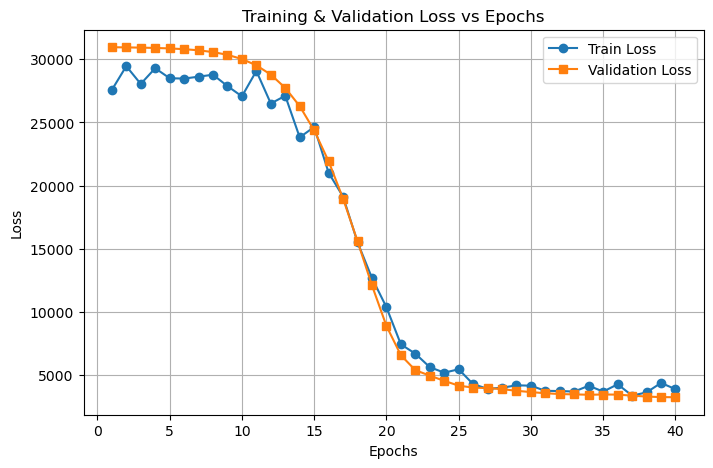

In [17]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    NN_model.train()
    epoch_loss = 0.0

    # Training loop
    for batch_x, batch_y in train_dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        logits = NN_model(batch_x)
        loss = criterion(logits, batch_y.view(-1, 1))  # binary classification shape fix

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation loop
    NN_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in val_dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            logits = NN_model(batch_x)
            loss = criterion(logits, batch_y.view(-1, 1))
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    #print(f"Epoch [{epoch+1}/{num_epochs}] "
    #      f"| Train Loss: {avg_train_loss:.4f} "
    #      f"| Val Loss: {avg_val_loss:.4f}")

# Plot losses
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, marker='s', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

As observed in the plot above, the loss decreases consistently over the epochs for both the training and validation datasets. This convergence indicates that the network is learning effectively and the model parameters are being optimized appropriately. Additionally, the similar trends in training and validation loss suggest that the model is not overfitting and is generalizing well to unseen data.

In [18]:
#Predictions
y_pred_ANFIS, _, _ = ANFIS_model(Xte)
y_pred = NN_model(Xte)

# Compute MSE for each
mse_ANFIS = mean_squared_error(yte.detach().numpy(), y_pred_ANFIS.detach().numpy())
mse_NN = mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())

print(f"MSE ANFIS: {mse_ANFIS}")
print(f'MSE Neural Network:{mse_NN}') #regression

MSE ANFIS: 2710.311279296875
MSE Neural Network:3569.83349609375


The performance of the two models was evaluated using Mean Squared Error (MSE). The ANFIS model achieved an MSE of 2803.84, while the Neural Network recorded a higher MSE of 3644.03. This indicates that the ANFIS model outperforms the Neural Network in terms of prediction accuracy on this dataset. The lower MSE suggests that ANFIS captures the underlying patterns more effectively, resulting in better generalization.

Even though neural networks are powerful universal function approximators, they do not always outperform ANFIS. Because ANFIS is rule-based, it can capture local, piecewise patterns in the data efficiently, particularly in smaller datasets or when strong clustered structures exist. In contrast, a multilayer perceptron with ReLU typically requires more data and careful hyperparameter tuning (e.g., learning rate, scaling, and regularization) to achieve good generalization. Without this, the network may underperform, leading to higher error.

### Classification

For the classification task, a similar training process was followed.
However, since the TSK fuzzy model operates on continuous outputs, it was necessary to transform the target values into binary form before training. This allowed the model to handle the problem in a regression-like framework, where the predicted continuous outputs could later be interpreted as class probabilities or thresholded into discrete labels.


In [19]:
# Load dataset
diabetes = datasets.fetch_openml("diabetes", version=1, as_frame=True)

# Get the full DataFrame (features + target)
df = diabetes.frame

# Replace string target with binary values directly
df["class"] = df["class"].map({
    "tested_negative": 0,
    "tested_positive": 1
})

# Define X and y from the updated DataFrame
X = df.drop(columns="class").values
y = df["class"].values

print(y[:10])
df.head()

[1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
Categories (2, int64): [0, 1]


preg  plas  pres  skin  insu  mass   pedi  age class
0     6   148    72    35     0  33.6  0.627   50     1
1     1    85    66    29     0  26.6  0.351   31     0
2     8   183    64     0     0  23.3  0.672   32     1
3     1    89    66    23    94  28.1  0.167   21     0
4     0   137    40    35   168  43.1  2.288   33     1

In [20]:
# First split into train+val and test
test_size = 0.2
Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=test_size, random_state=42
)

# Now split train into actual train and validation
val_size = 0.2  # 20% of train becomes validation
Xtr, Xval, ytr, yval = train_test_split(
    Xtr, ytr, test_size=val_size, random_state=42
)

In [21]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)
Xval= scaler.transform(Xval)

In [22]:
# Number of clusters 
n_clusters = 2
m= 1.5

# Concatenate target for clustering
Xexp=np.concatenate([Xtr, ytr.reshape(-1, 1)], axis=1)
#Xexp=Xtr

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T 

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

In [23]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)# Hard clustering from fuzzy membership

Fuzzy partition coefficient (FPC): 0.6597570816861353


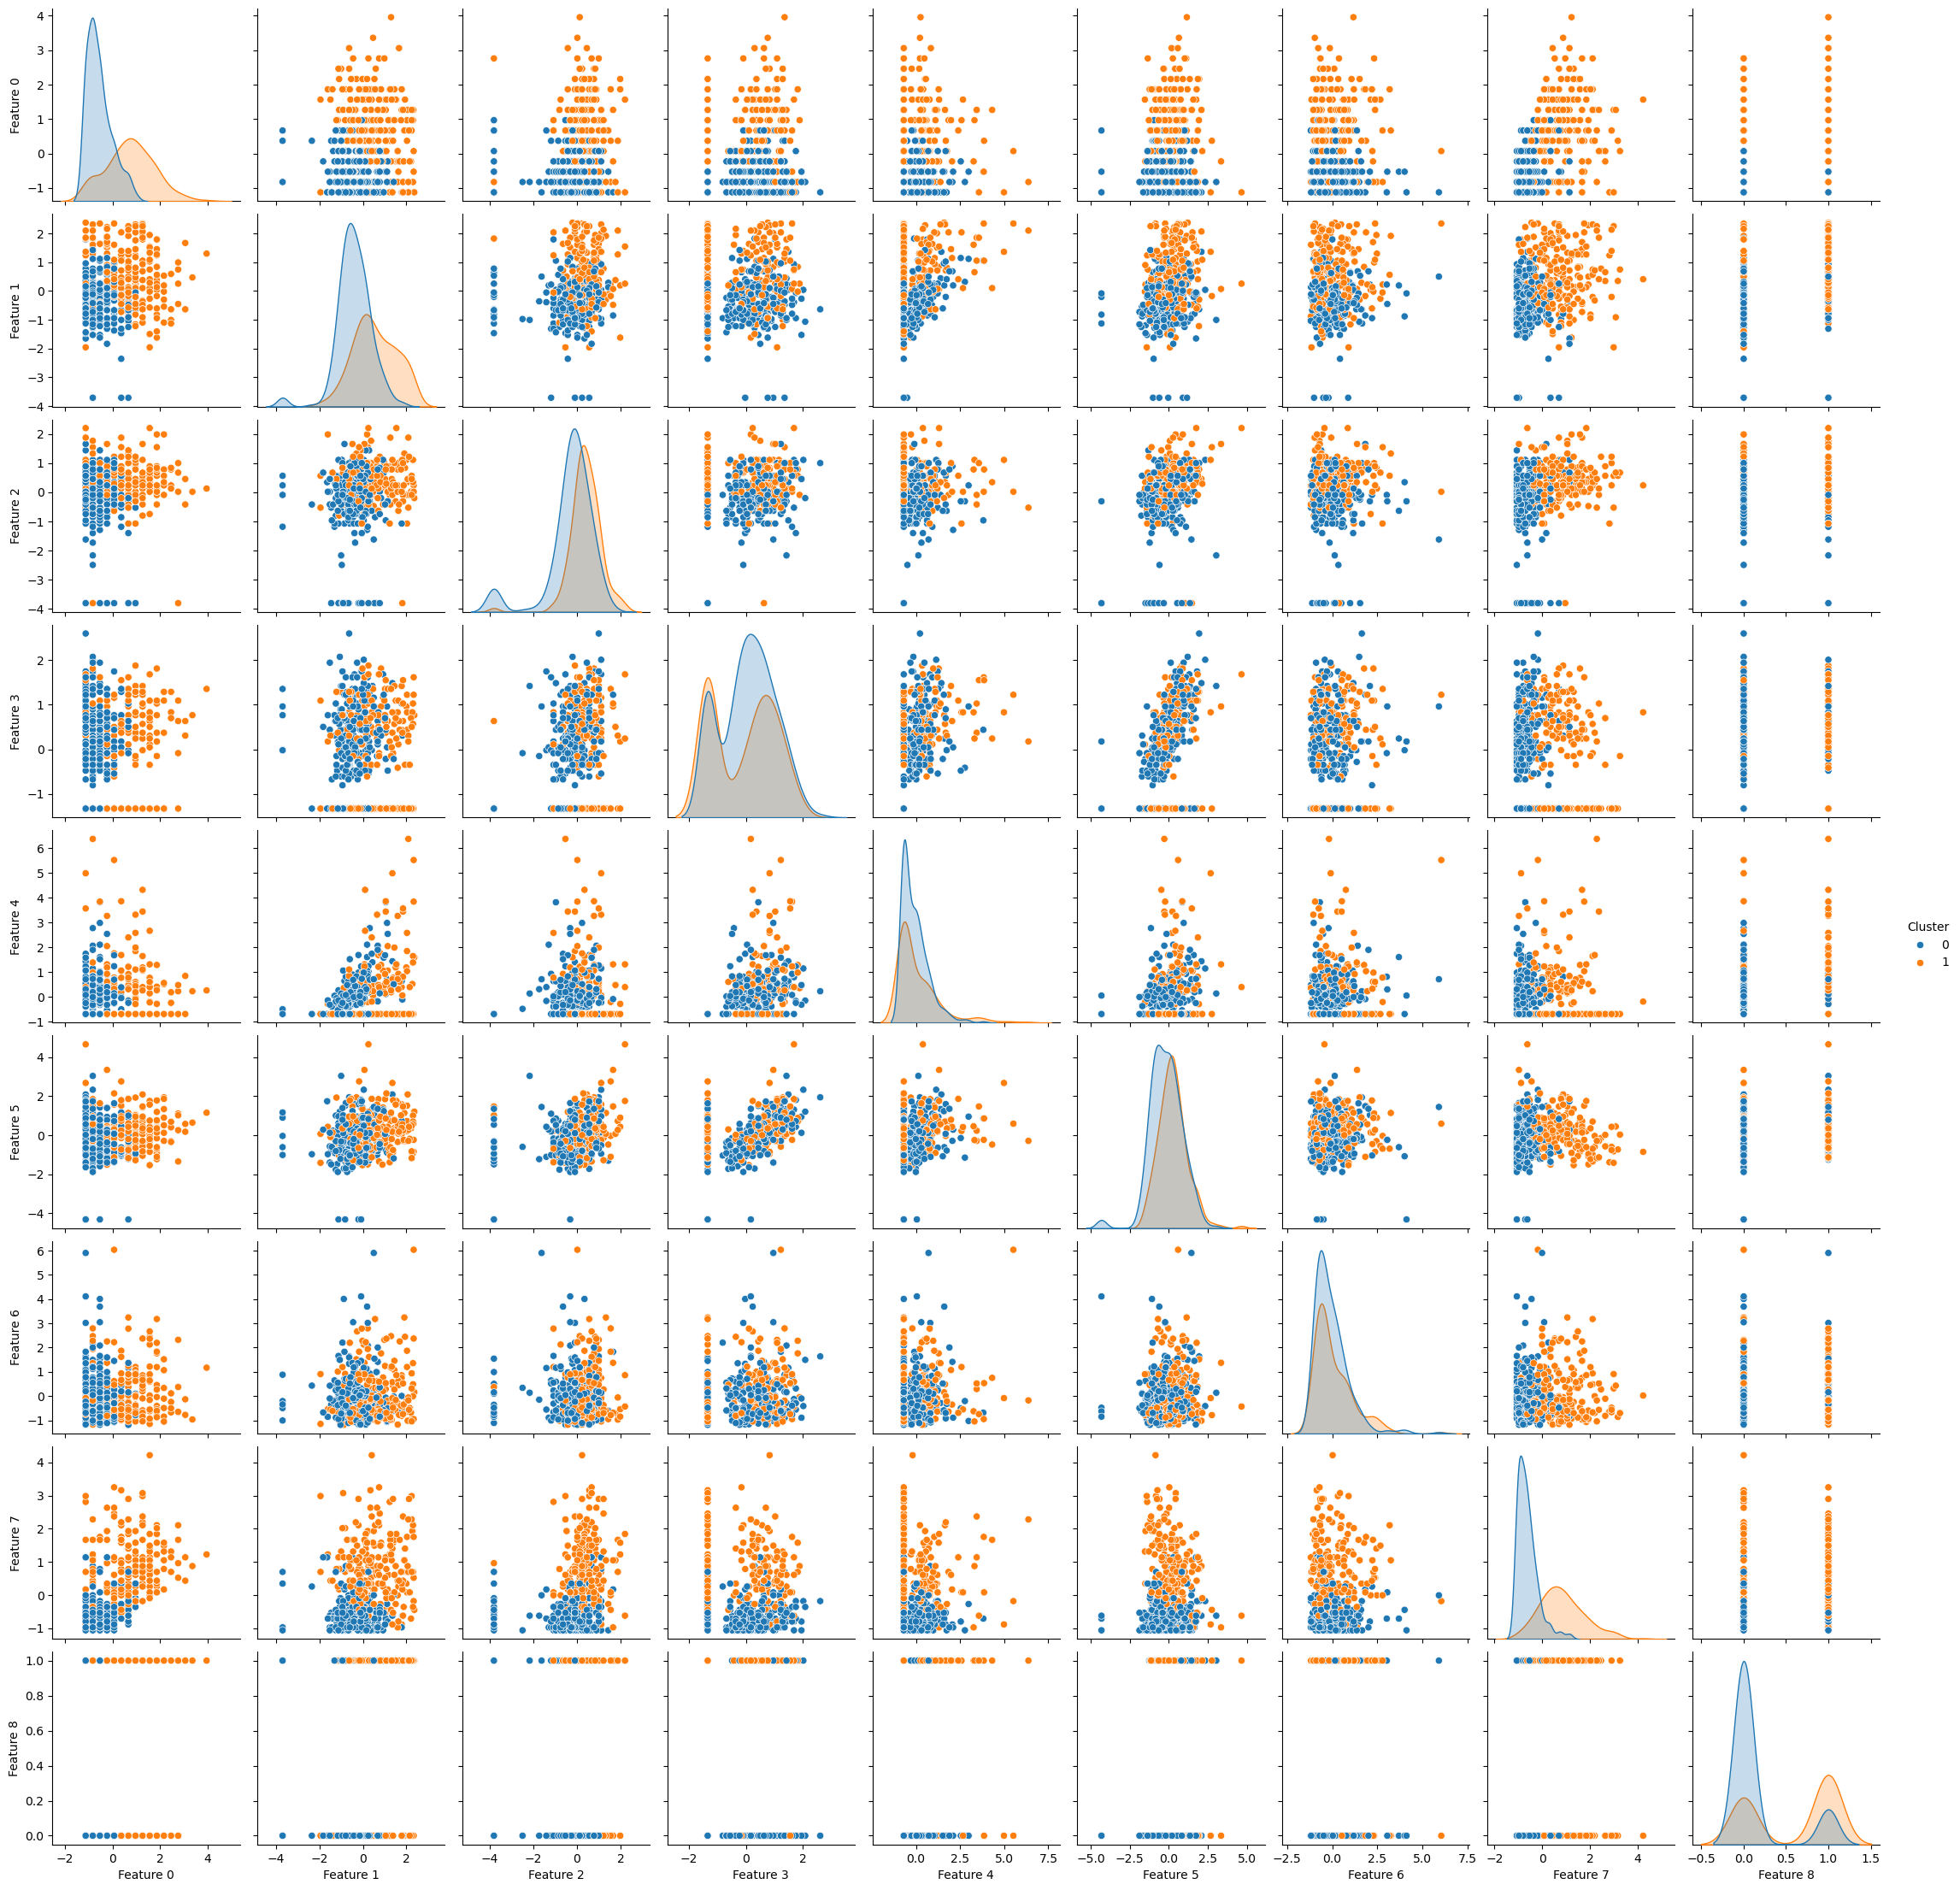

In [24]:
# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)

cluster_labels = np.argmax(u, axis=0)  

# Turn Xexp into a dataframe for plotting
df = pd.DataFrame(Xexp, columns=[f"Feature {i}" for i in range(Xexp.shape[1])])
df["Cluster"] = cluster_labels

# Pairplot with hue = cluster
sns.pairplot(df, vars=df.columns[:-1], hue="Cluster", palette="tab10", diag_kind="kde")
plt.show()

In [25]:
num_epochs=20
lr=0.0005
dropout=0.1
batch_size=64

In [26]:
# Build ANFIS Model
ANFIS_model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

# Convert to tensors
Xtr  = torch.tensor(Xtr, dtype=torch.float32)
ytr  = torch.tensor(ytr, dtype=torch.float32)
Xval = torch.tensor(Xval, dtype=torch.float32)
yval = torch.tensor(yval, dtype=torch.float32)
Xte  = torch.tensor(Xte, dtype=torch.float32)
yte  = torch.tensor(yte, dtype=torch.float32)

In [27]:
#Training with ANFIS
train_hybrid_anfis(ANFIS_model, Xtr, ytr.reshape(-1,1), max_iters=10, gd_epochs=20, lr=1e-3)

In [28]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size=1, dropout_prob=0.5):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.out = nn.Linear(64, output_size)
        
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        
        x = self.out(x)
        return x

In [29]:
# Wrap into TensorDatasets
train_dataset = TensorDataset(Xtr, ytr)
val_dataset   = TensorDataset(Xval, yval)
test_dataset  = TensorDataset(Xte, yte)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NN_model = MLP(input_size=Xtr.shape[1], dropout_prob=dropout).to(device)
criterion = nn.BCEWithLogitsLoss()  # for binary classification
criterion = nn.MSELoss() #for regression
optimizer = optim.Adam(NN_model.parameters(), lr=lr)

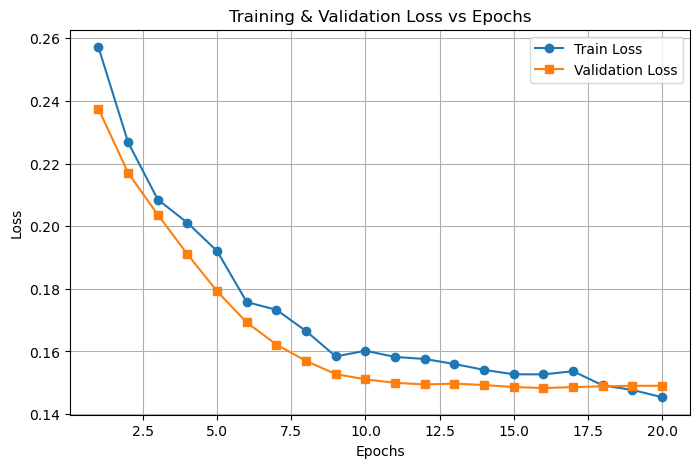

In [30]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    NN_model.train()
    epoch_loss = 0.0

    # Training loop
    for batch_x, batch_y in train_dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        logits = NN_model(batch_x)
        loss = criterion(logits, batch_y.view(-1, 1))  # binary classification shape fix

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation loop
    NN_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in val_dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            logits = NN_model(batch_x)
            loss = criterion(logits, batch_y.view(-1, 1))
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    #print(f"Epoch [{epoch+1}/{num_epochs}] "
    #      f"| Train Loss: {avg_train_loss:.4f} "
    #      f"| Val Loss: {avg_val_loss:.4f}")

# Plot losses
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, marker='s', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# Predictions (binary classification: threshold at 0.5)
y_pred_ANFIS = (ANFIS_model(Xte)[0] >= 0.5).int()
y_pred_NN    = (NN_model(Xte)      >= 0.5).int()

# Accuracy
acc_ANFIS = accuracy_score(yte.detach().numpy(), y_pred_ANFIS.detach().numpy())
acc_NN    = accuracy_score(yte.detach().numpy(), y_pred_NN.detach().numpy())

print(f"Accuracy ANFIS: {acc_ANFIS:.4f}")
print(f"Accuracy NN: {acc_NN:.4f}")

Accuracy ANFIS: 0.7532
Accuracy NN: 0.7403


For the classification task, the models were evaluated using accuracy. The ANFIS model achieved an accuracy of 0.7532, slightly higher than the Neural Network’s accuracy of 0.7403. This further confirms that ANFIS performs better in capturing the patterns in the data, leading to more correct predictions compared to the Neural Network.